In [13]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import json

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [14]:
project_name = '05b-cifar10-resnet'

In [16]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
try:
    x = os.listdir('./data/cifar10')
    print("Files already extracted")
except:
    with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
        tar.extractall(path='./data')
    
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

Using downloaded and verified file: .\cifar10.tgz
Files already extracted
['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [17]:
stats = ((.4914, .4822, .4465), (0.2023, .1994, .2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
tt.RandomHorizontalFlip(),
# tt.RandomRotate
# tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
# tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1,
tt.ToTensor(),
tt.Normalize(*stats, inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [18]:
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [19]:
batch_size = 400

In [20]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [21]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means
    
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        images = denormalize(images, *stats)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1,2,0).clamp(0,1))
        break

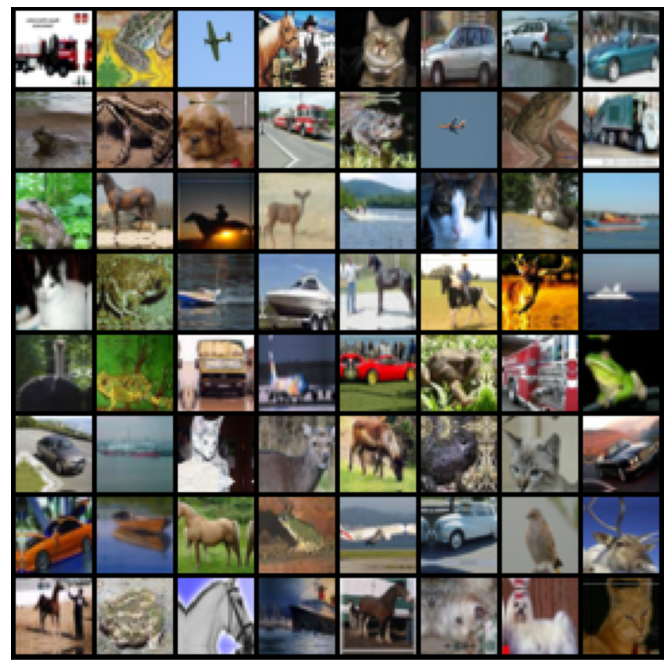

In [42]:
show_batch(train_dl)

In [22]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [23]:
device = get_default_device()
device

device(type='cuda')

In [24]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [25]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input


In [47]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break

del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])


In [26]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self.forward(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [32]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
    nn.BatchNorm2d(out_channels),
    nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128,128))
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512,512))
        self.classifier = nn.Sequential(nn.MaxPool2d(4), nn.Flatten(), nn.Dropout(.2), nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [27]:
model = to_device(ResNet9(3, 10), device)
model

NameError: name 'ResNet9' is not defined

In [28]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_function=torch.optim.SGD):

    torch.cuda.empty_cache()
    history = []

    optimizer = opt_function(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            sched.step()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [52]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.308304786682129, 'val_acc': 0.09615384787321091}]

In [29]:
epochs = 8
max_lr = 0.01
grad_clip = .1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [56]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, grad_clip=grad_clip, weight_decay=weight_decay, opt_function=opt_func)

Epoch [0], last_lr: 0.00393, train_loss: 1.5380, val_loss: 1.8434, val_acc: 0.4774
Epoch [1], last_lr: 0.00935, train_loss: 1.1134, val_loss: 1.2195, val_acc: 0.6005
Epoch [2], last_lr: 0.00972, train_loss: 0.8614, val_loss: 0.7895, val_acc: 0.7349
Epoch [3], last_lr: 0.00812, train_loss: 0.6385, val_loss: 0.8842, val_acc: 0.7042
Epoch [4], last_lr: 0.00556, train_loss: 0.5215, val_loss: 0.5610, val_acc: 0.8132
Epoch [5], last_lr: 0.00283, train_loss: 0.4004, val_loss: 0.4179, val_acc: 0.8651
Epoch [6], last_lr: 0.00077, train_loss: 0.2973, val_loss: 0.3037, val_acc: 0.8960
Epoch [7], last_lr: 0.00000, train_loss: 0.2284, val_loss: 0.2809, val_acc: 0.9048
Wall time: 5min 7s


In [57]:
train_time = '4:24'

In [37]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

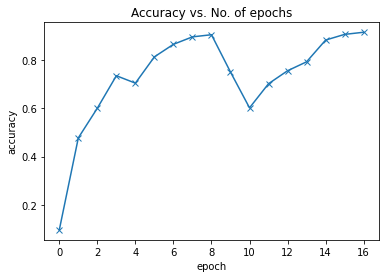

In [38]:
plot_accuracies(history)

In [36]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

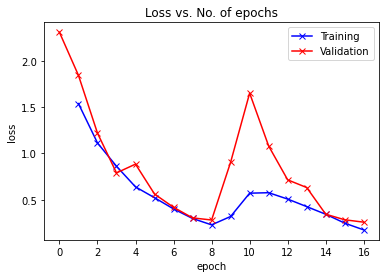

In [39]:
plot_losses(history)

In [3]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

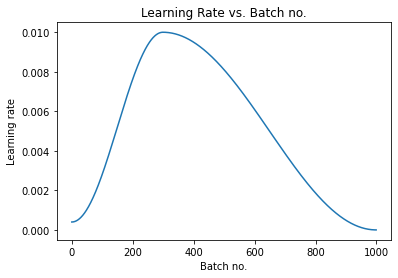

In [4]:
plot_lrs(history)

In [73]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

In [100]:
def show_pred_image(model, img, label):
    image = denormalize(img, *stats)
    plt.imshow(image[0].permute(1, 2, 0).clamp(0, 1))
    print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: airplane , Predicted: airplane


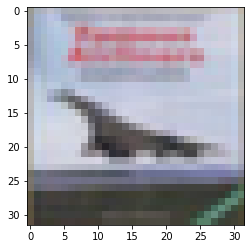

In [101]:
show_pred_image(model, *valid_ds[0])

Label: automobile , Predicted: automobile


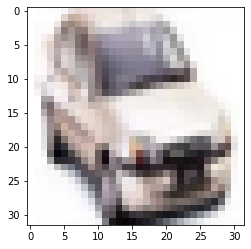

In [102]:
show_pred_image(model, *valid_ds[1234])

Label: dog , Predicted: dog


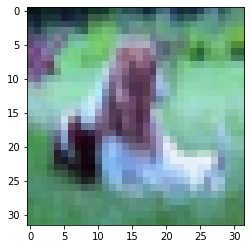

In [103]:
show_pred_image(model, *valid_ds[5932])

Label: airplane , Predicted: airplane


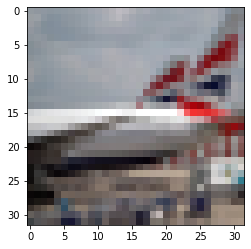

In [119]:
show_pred_image(model, *valid_ds[578])

In [40]:
torch.save(model.state_dict(), 'cifar10-resnet9.pth')

json = json.dumps(history)
f = open('history.json', 'w')
f.write(json)
f.close()

In [33]:
model2 = to_device(ResNet9(3,10), device)

In [34]:
model2.load_state_dict(torch.load('cifar10-resnet9.pth'))

<All keys matched successfully>

In [98]:
evaluate(model2, valid_dl)

{'val_loss': 0.2809290587902069, 'val_acc': 0.9048076272010803}

Label: airplane , Predicted: airplane


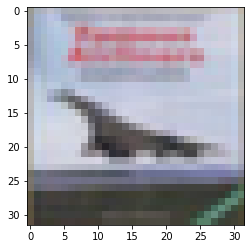

In [122]:
show_pred_image(model2, *valid_ds[0])

In [2]:
with open("history.json") as file:
    history = json.load(file)

36, 0.004174087221843185, 0.004223411137347356, 0.004272842864364431, 0.004322376945829026, 0.004372007913376237, 0.004421730287945321, 0.0044715385803845665, 0.0045214272920572705, 0.004571390915448771, 0.004621423934774449, 0.004671520826588648, 0.004721676060394449, 0.004771884099254205, 0.004822139400400809, 0.004872436415849579, 0.0049227695930107425, 0.004973133375302422, 0.005023522202764049, 0.005073930512670173, 0.005124352740144561, 0.00517478331877453, 0.005225216681225468, 0.005275647259855438, 0.005326069487329825, 0.005376477797235949, 0.005426866624697577, 0.005477230406989256, 0.00552756358415042, 0.00557786059959919, 0.005628115900745793, 0.00567832393960555, 0.00572847917341135, 0.00577857606522555, 0.0058286090845512265, 0.0058785727079427265, 0.005928461419615432, 0.005978269712054677, 0.006027992086623761, 0.006077623054170971, 0.006127157135635566, 0.006176588862652641, 0.006225912778156813, 0.006275123436984662, 0.00632421540647585, 0.00637318326707287, 0.0064220

In [11]:
for x, epoch in enumerate(history):
    print("Epoch [{}]: Loss: {:.4f},  Accuracy: {:.4f}".format(x, epoch["val_loss"], epoch["val_acc"]))

Epoch [0]: Loss: 2.3083,  Accuracy: 0.0962
Epoch [1]: Loss: 1.8434,  Accuracy: 0.4774
Epoch [2]: Loss: 1.2195,  Accuracy: 0.6005
Epoch [3]: Loss: 0.7895,  Accuracy: 0.7349
Epoch [4]: Loss: 0.8842,  Accuracy: 0.7042
Epoch [5]: Loss: 0.5610,  Accuracy: 0.8132
Epoch [6]: Loss: 0.4179,  Accuracy: 0.8651
Epoch [7]: Loss: 0.3037,  Accuracy: 0.8960
Epoch [8]: Loss: 0.2809,  Accuracy: 0.9048


In [35]:
%%time
history += fit_one_cycle(epochs, max_lr, model2, train_dl, valid_dl, grad_clip=grad_clip, weight_decay=weight_decay, opt_function=opt_func)

Epoch [0], last_lr: 0.00393, train_loss: 0.3190, val_loss: 0.9050, val_acc: 0.7501
Epoch [1], last_lr: 0.00935, train_loss: 0.5705, val_loss: 1.6508, val_acc: 0.6019
Epoch [2], last_lr: 0.00972, train_loss: 0.5756, val_loss: 1.0795, val_acc: 0.7019
Epoch [3], last_lr: 0.00812, train_loss: 0.5068, val_loss: 0.7143, val_acc: 0.7556
Epoch [4], last_lr: 0.00556, train_loss: 0.4254, val_loss: 0.6314, val_acc: 0.7926
Epoch [5], last_lr: 0.00283, train_loss: 0.3429, val_loss: 0.3434, val_acc: 0.8827
Epoch [6], last_lr: 0.00077, train_loss: 0.2468, val_loss: 0.2832, val_acc: 0.9062
Epoch [7], last_lr: 0.00000, train_loss: 0.1738, val_loss: 0.2575, val_acc: 0.9151
Wall time: 4min 58s


In [42]:
epochs = 16
max_lr = 0.001
grad_clip = .1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [44]:
model3 = to_device(ResNet9(3, 10), device)

In [45]:
%%time
history += fit_one_cycle(epochs, max_lr, model3, train_dl, valid_dl, grad_clip=grad_clip, weight_decay=weight_decay, opt_function=opt_func)

Epoch [0], last_lr: 0.00014, train_loss: 1.7516, val_loss: 1.1906, val_acc: 0.5782
Epoch [1], last_lr: 0.00039, train_loss: 1.2251, val_loss: 0.9496, val_acc: 0.6674
Epoch [2], last_lr: 0.00070, train_loss: 0.9510, val_loss: 0.8978, val_acc: 0.6838
Epoch [3], last_lr: 0.00094, train_loss: 0.7753, val_loss: 1.0148, val_acc: 0.6715
Epoch [4], last_lr: 0.00100, train_loss: 0.6436, val_loss: 1.0091, val_acc: 0.6967
Epoch [5], last_lr: 0.00097, train_loss: 0.5612, val_loss: 1.0366, val_acc: 0.7012
Epoch [6], last_lr: 0.00091, train_loss: 0.4942, val_loss: 0.5542, val_acc: 0.8095
Epoch [7], last_lr: 0.00081, train_loss: 0.4300, val_loss: 0.4948, val_acc: 0.8284
Epoch [8], last_lr: 0.00069, train_loss: 0.3834, val_loss: 0.5890, val_acc: 0.8036
Epoch [9], last_lr: 0.00056, train_loss: 0.3285, val_loss: 0.4418, val_acc: 0.8518
Epoch [10], last_lr: 0.00042, train_loss: 0.2901, val_loss: 0.3647, val_acc: 0.8830
Epoch [11], last_lr: 0.00028, train_loss: 0.2496, val_loss: 0.3438, val_acc: 0.8868
Ep